In [1]:
import torch
import torch.nn as nn
from torch.func import functional_call, vmap, vjp, jvp, jacrev
device = 'cuda' if torch.cuda.device_count() > 0 else 'cpu'
import math

In [2]:
class MLPModel(torch.nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        layers = [torch.nn.Linear(x_dim, 16),
                  torch.nn.ReLU(),
                  torch.nn.Linear(16, 8),
                  torch.nn.ReLU(),
                  torch.nn.Linear(8, y_dim),
                  ]

        self.x_to_hidden = torch.nn.Sequential(*layers)

    def forward(self, x):
        h = self.x_to_hidden(x)
        y = torch.special.erf(h)

        return y

In [3]:
train_x = torch.linspace(0, 1, 100)[torch.randint(0,100, (75,))].reshape(-1,1)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)
test_x = torch.linspace(0, 1, 51).reshape(-1,1)

In [4]:
mlp = MLPModel(train_x.shape[-1], train_y.shape[-1]).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.1)
dataset = torch.utils.data.TensorDataset(train_x, train_y)
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
for epoch in range(100):
    epoch_loss = []
    for xb, yb in loader:
        optimizer.zero_grad()
        y_pred = mlp(xb)
        loss = torch.nn.functional.mse_loss(yb, y_pred)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    print("Epoch %d - Loss : %.2f"%(epoch, sum(epoch_loss)/len(epoch_loss)))

Epoch 0 - Loss : 0.72
Epoch 1 - Loss : 0.36
Epoch 2 - Loss : 0.24
Epoch 3 - Loss : 0.16
Epoch 4 - Loss : 0.18
Epoch 5 - Loss : 0.23
Epoch 6 - Loss : 0.16
Epoch 7 - Loss : 0.13
Epoch 8 - Loss : 0.12
Epoch 9 - Loss : 0.12
Epoch 10 - Loss : 0.14
Epoch 11 - Loss : 0.15
Epoch 12 - Loss : 0.14
Epoch 13 - Loss : 0.16
Epoch 14 - Loss : 0.14
Epoch 15 - Loss : 0.16
Epoch 16 - Loss : 0.17
Epoch 17 - Loss : 0.14
Epoch 18 - Loss : 0.14
Epoch 19 - Loss : 0.13
Epoch 20 - Loss : 0.15
Epoch 21 - Loss : 0.14
Epoch 22 - Loss : 0.14
Epoch 23 - Loss : 0.14
Epoch 24 - Loss : 0.15
Epoch 25 - Loss : 0.13
Epoch 26 - Loss : 0.15
Epoch 27 - Loss : 0.21
Epoch 28 - Loss : 0.13
Epoch 29 - Loss : 0.21
Epoch 30 - Loss : 0.15
Epoch 31 - Loss : 0.14
Epoch 32 - Loss : 0.14
Epoch 33 - Loss : 0.12
Epoch 34 - Loss : 0.15
Epoch 35 - Loss : 0.13
Epoch 36 - Loss : 0.13
Epoch 37 - Loss : 0.13
Epoch 38 - Loss : 0.14
Epoch 39 - Loss : 0.19
Epoch 40 - Loss : 0.16
Epoch 41 - Loss : 0.13
Epoch 42 - Loss : 0.14
Epoch 43 - Loss : 0.1

In [5]:
# Detaching the parameters because we won't be calling Tensor.backward().
params = {k: v.detach() for k, v in mlp.named_parameters()}

def fnet_single(params, x):
    return functional_call(mlp, params, (x.unsqueeze(0),)).squeeze(0)

def empirical_ntk_jacobian_contraction(fnet_single, params, x1, x2, compute='full'):
    # Compute J(x1)
    jac1 = vmap(jacrev(fnet_single), (None, 0))(params, x1)
    jac1 = jac1.values()
    jac1 = [j.flatten(2) for j in jac1]

    # Compute J(x2)
    jac2 = vmap(jacrev(fnet_single), (None, 0))(params, x2)
    jac2 = jac2.values()
    jac2 = [j.flatten(2) for j in jac2]

    # Compute J(x1) @ J(x2).T
    einsum_expr = None
    if compute == 'full':
        einsum_expr = 'Naf,Mbf->NMab'
    elif compute == 'trace':
        einsum_expr = 'Naf,Maf->NM'
    elif compute == 'diagonal':
        einsum_expr = 'Naf,Maf->NMa'
    else:
        assert False

    result = torch.stack([torch.einsum(einsum_expr, j1, j2) for j1, j2 in zip(jac1, jac2)])
    result = result.sum(0)
    return result

result = empirical_ntk_jacobian_contraction(fnet_single, params, test_x, test_x, 'full')

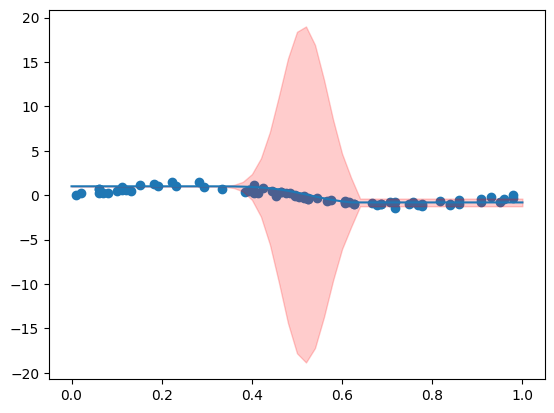

In [6]:
import matplotlib.pyplot as plt 

std = result.squeeze().diag()

fig, ax = plt.subplots()
ax.scatter(train_x.squeeze(), train_y.squeeze())
with torch.no_grad():
    y_pred = mlp(test_x).squeeze()
ax.plot(test_x.squeeze(), y_pred)
plt.fill_between(test_x.squeeze(),
                 y_pred - 2 * std,
                 y_pred + 2 * std,
                 color='red', 
                 alpha=0.2
                 )
plt.show()